https://www.kaggle.com/datasets/kukuroo3/used-car-price-dataset-competition-format?select=X_train.csv

In [96]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression as LogReg
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import seaborn as sns
from impementation import *

In [5]:
X_train = pd.read_csv("data/X_train.csv")
y_train = pd.read_csv("data/y_train.csv")
X_test = pd.read_csv("data/X_test.csv")
y_test = pd.read_csv("data/test_label/y_test.csv")

In [6]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4960, 10), (4960, 2), (2672, 10), (2672, 2))

In [7]:
X_train.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0


In [11]:
X = pd.concat([X_train,X_test])
y = pd.concat([y_train,y_test])

In [13]:
X.shape, y.shape

((7632, 10), (7632, 2))

In [14]:
y.head()

,carID,price
0,13207,31995
1,17314,7700
2,12342,58990
3,13426,12999
4,16004,16990


In [15]:
df = pd.merge(X,y, on='carID')

In [16]:
df.shape

(7632, 11)

In [17]:
df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


In [18]:
df.describe()

,carID,year,mileage,tax,mpg,engineSize,price
count,7632.00000,7632.000000,7632.000000,7632.000000,7632.000000,7632.000000,7632.000000
mean,15815.50000,2016.731787,24837.685928,152.657888,50.166483,2.128132,23579.922825
std,2203.31296,2.889072,23994.794380,81.821950,35.579174,0.782125,16474.496951
min,12000.00000,1970.000000,1.000000,0.000000,2.800000,0.000000,450.000000
25%,13907.75000,2016.000000,5800.000000,145.000000,38.200000,1.600000,12215.250000
50%,15815.50000,2017.000000,18891.000000,145.000000,47.100000,2.000000,19200.000000
75%,17723.25000,2019.000000,36500.250000,150.000000,54.300000,2.800000,30490.000000
max,19631.00000,2020.000000,259000.000000,580.000000,470.800000,6.600000,159999.000000


In [20]:
df.duplicated().sum()

0

In [22]:
len(df['carID'].unique()) == df.shape[0]

True

## Baseline

In [24]:
X = df.drop(columns=['price'])
y = df['price']

In [25]:
cat_cols = []
for col in X.columns:
    if X[col].dtype == object:
        cat_cols.append(col)

In [26]:
cat_cols

['brand', 'model', 'transmission', 'fuelType']

In [27]:
X_clean = X.copy()

In [28]:
for col in cat_cols:
    encoder = LabelEncoder()
    X_clean[col] = encoder.fit_transform(X_clean[col])

In [29]:
X_clean.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
0,13207,3,69,2019,3,4223,0,145.0,39.8,2.2
1,17314,7,30,2015,1,47870,0,125.0,60.1,2.0
2,12342,0,58,2019,0,5151,4,145.0,29.1,2.9
3,13426,8,71,2016,0,20423,0,30.0,57.6,2.0
4,16004,5,70,2020,3,3569,4,145.0,47.1,1.0


In [100]:
train_X, test_X, train_y, test_y = train_test_split(X_clean,y, test_size=0.2, random_state=42)

In [101]:
train_X.shape, test_X.shape, train_y.shape, test_y.shape

((6105, 10), (1527, 10), (6105,), (1527,))

In [102]:
def pipeline_imp(models, train_X, train_y, test_X, test_y):

        results = {}

        for model_name, model in models.items():
                print(f"Training and evaluating model: {model_name}")

                model.fit(train_X, train_y)

                y_pred = model.predict(test_X)

                # Вычисление метрики (например, RMSE)
                rmse = np.sqrt(mean_squared_error(test_y, y_pred))
                print(f"mse = {mean_squared_error(test_y, y_pred)}")
                print(f"mae = {mean_absolute_error(test_y, y_pred)}")
                print(f"r2 = {r2_score(test_y, y_pred)}")
                print("RMSE на тестовой выборке:", rmse)
                print


                results[model_name] = {"r2": r2_score(test_y, y_pred), "rmse": rmse}
        

        return results

In [103]:
knn = KNeighborsRegressor()
logreg = LogReg(random_state=42)
decision_tree = DecisionTreeRegressor(random_state=42)
random_forest = RandomForestRegressor(random_state=42)
gradient_boosting = GradientBoostingRegressor(random_state=42)


In [104]:
# Словарь моделей для пайплайна
models = {
    "KNN": knn,
    "Logistic Regression": logreg,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting,
}

In [105]:
results = pipeline_imp(models, train_X, train_y, test_X, test_y)

Training and evaluating model: KNN
mse = 233751136.9250295
mae = 10712.102030124426
r2 = 0.18810245046287843
RMSE на тестовой выборке: 15288.922032799745
Training and evaluating model: Logistic Regression


/Users/dmitry/Desktop/project/pinn_venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


mse = 257818309.87884742
mae = 10929.691552062868
r2 = 0.10450893728241462
RMSE на тестовой выборке: 16056.721641694092
Training and evaluating model: Decision Tree
mse = 26152618.93254748
mae = 2704.797642436149
r2 = 0.909163020532715
RMSE на тестовой выборке: 5113.963133671134
Training and evaluating model: Random Forest
mse = 14582803.64483294
mae = 2164.3198231827114
r2 = 0.9493489413554459
RMSE на тестовой выборке: 3818.7437259958856
Training and evaluating model: Gradient Boosting
mse = 21873632.569032304
mae = 3208.5600408951836
r2 = 0.9240254019043828
RMSE на тестовой выборке: 4676.925546663353


##  EDA

In [38]:
df.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,hyundi,Santa Fe,2019,Semi-Auto,4223,Diesel,145.0,39.8,2.2,31995
1,17314,vauxhall,GTC,2015,Manual,47870,Diesel,125.0,60.1,2.0,7700
2,12342,audi,RS4,2019,Automatic,5151,Petrol,145.0,29.1,2.9,58990
3,13426,vw,Scirocco,2016,Automatic,20423,Diesel,30.0,57.6,2.0,12999
4,16004,skoda,Scala,2020,Semi-Auto,3569,Petrol,145.0,47.1,1.0,16990


In [43]:
df_clean = df.copy()

## Numeric feature

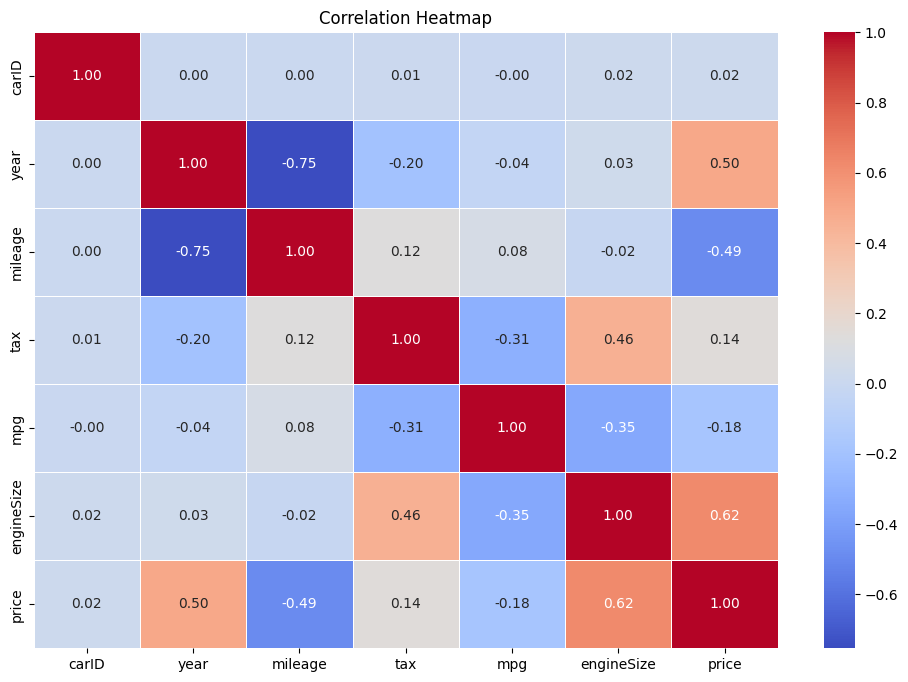

In [39]:
# Filter only numeric columns
df_numeric = df.select_dtypes(include=[np.number])

# 5. Correlation Heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

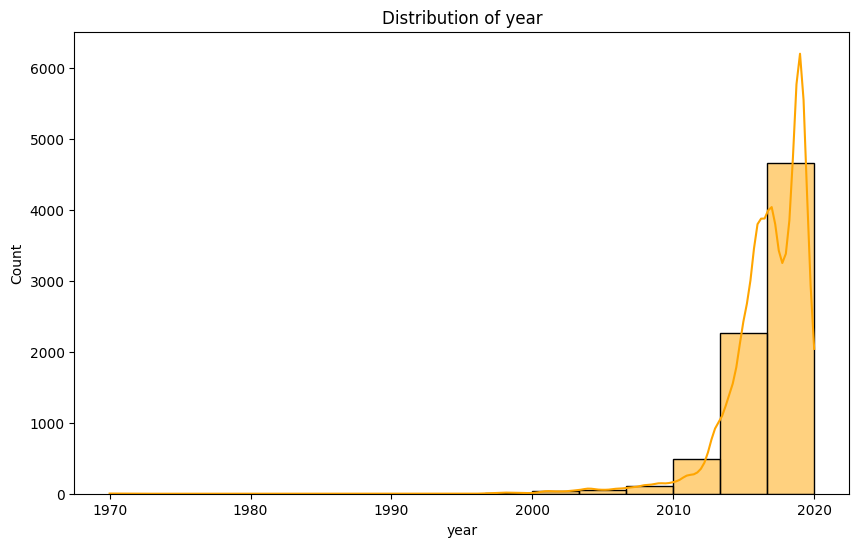

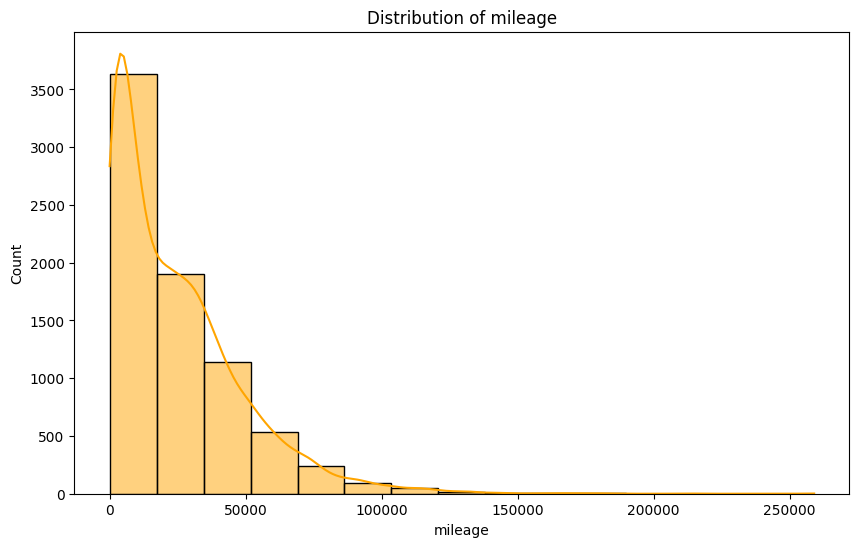

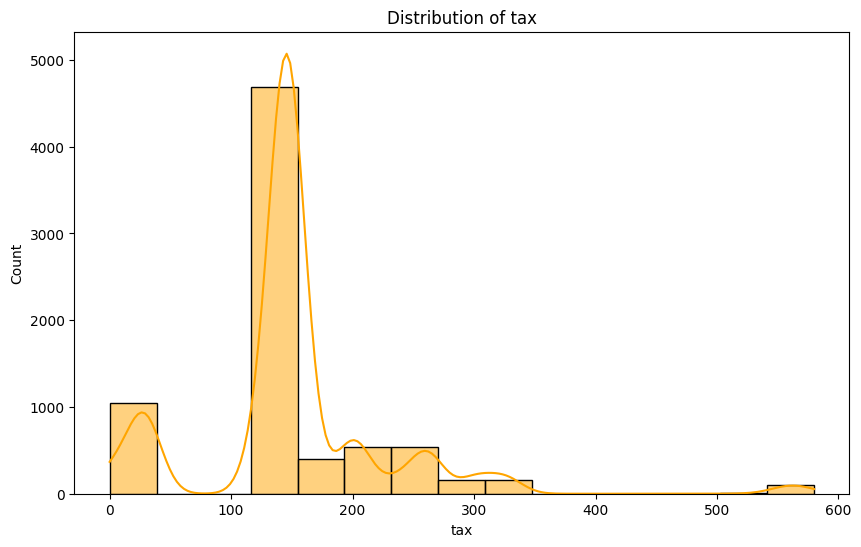

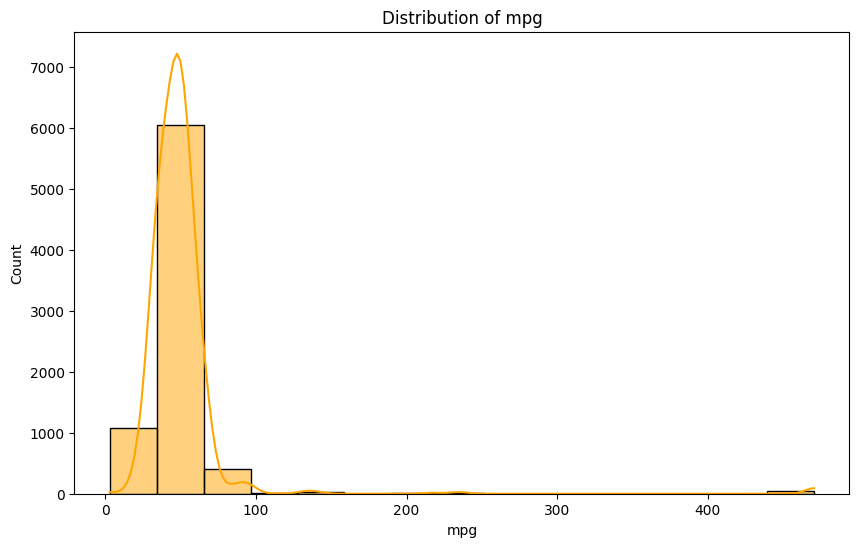

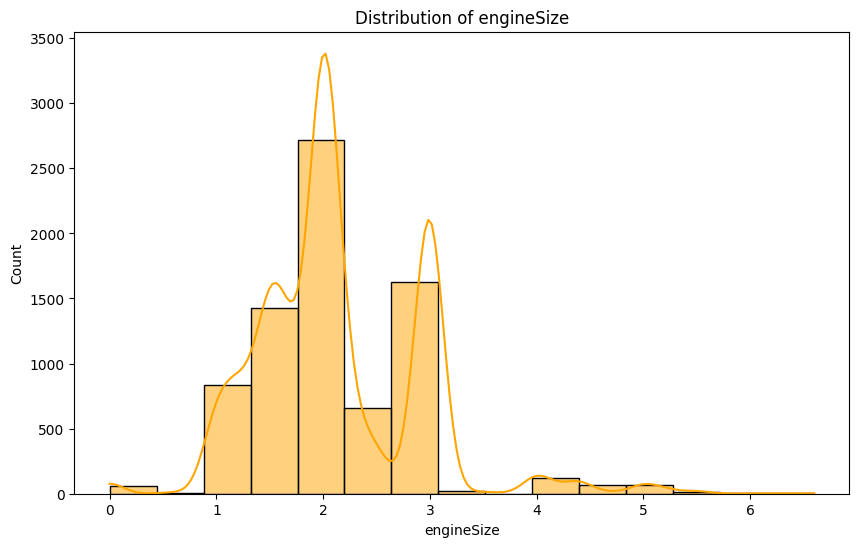

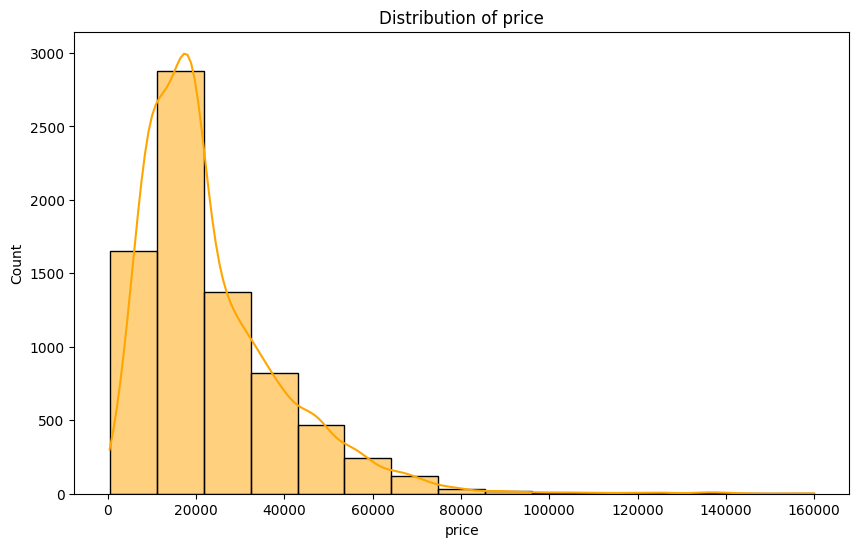

In [ ]:
for col in df_numeric.columns[1:]:
    # 7. Distribution of Annual Income
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], bins=15, kde=True, color='orange')
    plt.title(f'Distribution of {col}')
    plt.show()

In [42]:
def iqr(data, feature):
    Q1 = data[feature].quantile(0.25)
    Q3 = data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

In [44]:
for col in ['mpg']:
    low, upp = iqr(df_clean, col)
    df_clean = df_clean[(df_clean[col] >=low) & (df_clean[col] <= upp)]

In [45]:
df_clean.shape

(7407, 11)

## Categorical feature

In [46]:
cat_cols

['brand', 'model', 'transmission', 'fuelType']

In [49]:
for col in cat_cols:
    print(col, len(df[col].unique()))

brand 9
model 90
transmission 4
fuelType 5


In [50]:
for col in cat_cols:
    encoder = LabelEncoder()
    df_clean[col] = encoder.fit_transform(df_clean[col])

In [51]:
df_clean.head()

,carID,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,13207,3,69,2019,3,4223,0,145.0,39.8,2.2,31995
1,17314,7,30,2015,1,47870,0,125.0,60.1,2.0,7700
2,12342,0,58,2019,0,5151,3,145.0,29.1,2.9,58990
3,13426,8,71,2016,0,20423,0,30.0,57.6,2.0,12999
4,16004,5,70,2020,3,3569,3,145.0,47.1,1.0,16990


In [52]:
num_cols = df_clean.columns[1:-1]

In [53]:
num_cols

Index(['brand', 'model', 'year', 'transmission', 'mileage', 'fuelType', 'tax',
       'mpg', 'engineSize'],
      dtype='object')

In [55]:
df_final = df_clean.drop(columns=['carID']).copy()

In [56]:
encoder = StandardScaler()
df_final[num_cols] = encoder.fit_transform(df_final[num_cols])

In [57]:
df_final.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,-0.370041,0.986435,0.777334,1.484061,-0.850302,-0.763473,-0.130415,-0.609772,0.068133,31995
1,1.216582,-0.508212,-0.591188,-0.209428,0.956705,-0.763473,-0.379525,1.294771,-0.189611,7700
2,-1.560008,0.564868,0.777334,-1.056173,-0.811882,1.329954,-0.130415,-1.613645,0.970238,58990
3,1.613238,1.063083,-0.249057,-1.056173,-0.179614,-0.763473,-1.562796,1.060221,-0.189611,12999
4,0.423271,1.024759,1.119465,1.484061,-0.877378,1.329954,-0.130415,0.075113,-1.478332,16990


In [58]:
train_X, test_X, train_y, test_y = train_test_split(df_final.drop(columns=['price']),df_final['price'], test_size=0.2, random_state=42)

In [59]:
model = KNeighborsRegressor(n_neighbors=3)

In [60]:
model.fit(train_X, train_y)

KNeighborsRegressor(n_neighbors=3)

In [61]:
predict = model.predict(test_X)

In [62]:
print(f"mse = {mean_squared_error(test_y, predict)}")
print(f"mae = {mean_absolute_error(test_y, predict)}")
print(f"r2 = {r2_score(test_y, predict)}")

mse = 14111349.417528866
mae = 2154.652496626181
r2 = 0.9441666065859314


## Cross Validation

In [74]:
def pipeline(model, parametrs, train_X, train_y, test_X, test_y):

    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=parametrs,
        n_iter=50,  # Количество итераций поиска
        scoring='neg_mean_squared_error',  # Оценка качества
        cv=5,  # Кросс-валидация
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    
    # Запуск поиска
    random_search.fit(train_X, train_y)
    
    # Вывод лучших параметров
    print("Лучшие параметры:", random_search.best_params_)
    
    # Лучшая модель
    best_model = random_search.best_estimator_
    
    # Предсказания на тестовых данных
    y_pred = best_model.predict(test_X)
    
    # Вычисление метрики (например, RMSE)
    rmse = np.sqrt(mean_squared_error(test_y, y_pred))
    print(f"mse = {mean_squared_error(test_y, y_pred)}")
    print(f"mae = {mean_absolute_error(test_y, y_pred)}")
    print(f"r2 = {r2_score(test_y, y_pred)}")
    print("RMSE на тестовой выборке:", rmse)
    
    return best_model


In [75]:
parametrs = {'n_neighbors' : [3, 5, 7, 9, 11], 'algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'],'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']}
model = KNeighborsRegressor()

In [76]:
best_knn = pipeline(model, parametrs, train_X, train_y, test_X, test_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'weights': 'distance', 'n_neighbors': 5, 'metric': 'manhattan', 'algorithm': 'kd_tree'}
mse = 10514569.991958022
mae = 1917.643214703307
r2 = 0.9583977332308481
RMSE на тестовой выборке: 3242.6177684022555


## Models for CV

In [78]:
from scipy.stats import randint, uniform

In [79]:
# Логистическая регрессия
logreg = LogisticRegression(random_state=42, max_iter=1000)
logreg_params = {
    'C': uniform(0.01, 10),  # Параметр регуляризации
    'solver': ['lbfgs', 'liblinear']  # Выбор алгоритма оптимизации
}

# Дерево решений
decision_tree = DecisionTreeRegressor(random_state=42)
tree_params = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Случайный лес
random_forest = RandomForestRegressor(random_state=42)
forest_params = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Градиентный бустинг
gradient_boosting = GradientBoostingRegressor(random_state=42)
boosting_params = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

In [ ]:
best_ridge = pipeline(logreg, logreg_params, train_X, train_y, test_X, test_y)
best_tree = pipeline(decision_tree, tree_params, train_X, train_y, test_X, test_y)
best_forest = pipeline(random_forest, forest_params, train_X, train_y, test_X, test_y)
best_boosting = pipeline(gradient_boosting, boosting_params, train_X, train_y, test_X, test_y)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'alpha': 9.709098521619943}
mse = 72677977.05455525
mae = 5574.683629178644
r2 = 0.7124401100588558
RMSE на тестовой выборке: 8525.137949297668
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'max_depth': 13, 'min_samples_leaf': 3, 'min_samples_split': 9}
mse = 17454021.765369818
mae = 2298.9847526055323
r2 = 0.9309408877174368
RMSE на тестовой выборке: 4177.801068190038
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'max_depth': 17, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 120}
mse = 10233882.50918259
mae = 1846.6416504773863
r2 = 0.9595083098446437
RMSE на тестовой выборке: 3199.0439992570577
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Лучшие параметры: {'learning_rate': 0.12236203565420874, 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 121}
mse = 8697872.965287592
m

## Implementation

In [91]:
knn = KNN(k=5, task="regression")
logreg = LogisticRegression(lr=0.01, n_iters=1000, task="regression")
decision_tree = DecisionTree(max_depth=13, task="regression")
random_forest = RandomForest(n_trees=120, max_depth=17, task="regression")
gradient_boosting = GradientBoosting(n_estimators=121, learning_rate=0.1, max_depth=7, task="regression")

# Словарь моделей для пайплайна
models = {
    "KNN": knn,
    "Logistic Regression": logreg,
    "Decision Tree": decision_tree,
    "Random Forest": random_forest,
    "Gradient Boosting": gradient_boosting,
}

In [92]:
results = pipeline_imp(models, train_X.values, train_y.values, test_X.values, test_y.values)

Training and evaluating model: KNN
mse = 18982598.813576248
mae = 2362.8570850202427
r2 = 0.9248928733730247
RMSE на тестовой выборке: 4356.902433332223
Training and evaluating model: Logistic Regression
mse = 72608388.05676828
mae = 5573.643294934181
r2 = 0.7127154479996698
RMSE на тестовой выборке: 8521.055571745104
Training and evaluating model: Decision Tree
mse = 19594606.071931258
mae = 2301.776824976561
r2 = 0.9224713868789298
RMSE на тестовой выборке: 4426.579500238447
Training and evaluating model: Random Forest
mse = 9711756.697746115
mae = 1831.5450794032788
r2 = 0.9615741686777728
RMSE на тестовой выборке: 3116.369152996178
Training and evaluating model: Gradient Boosting
mse = 562902668.8175031
mae = 23536.2242953133
r2 = -1.22719778470488
RMSE на тестовой выборке: 23725.56993662119
